# Explore
### A notebook for my initial explorations of the PCWG CESM/COSP outputs for satellite observation comparisons.
##### Initialized by Drew Camron 01/2018
---

In [1]:
%matplotlib inline
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='talk')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54010 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
# Working directory
indir = ('/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_cesm1_1_2_LENS_n16_cosp1.4_opaq_prec/'+
        'cesm112LENS_FAMIPC5.f09_f09.001_cosp1.4_opaq_prec/atm/hist/')

Jen's data in this directory feature
* `h0` history fields of monthly mean general outputs featuring COSP diagnostics
* `h1` history fields of daily **(instantaneous?)** outputs of just cloud quantities

from 2006 through 2015. So, let's look at a year of monthly data and practice narrowing our analysis to Greenland!

In [4]:
# Reading in all years of monthly mean data and attempt to slice to Greenland bounds
ds = xr.open_mfdataset(indir+'cesm112LENS_FAMIPC5.f09_f09.001_cosp1.4_opaq_prec.cam.h0.*.nc')
ds = ds.sel(lat=slice(0, 90))

Being new to this, I'll take a look at one month of CLDTOT *vertically-integrated total cloud fraction* to work on my Polar Stereographic chops.

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


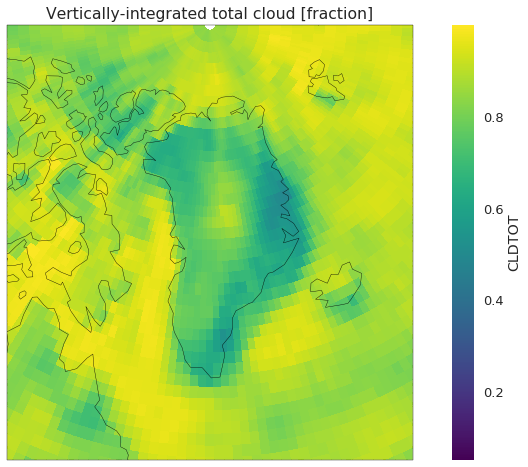

In [5]:
var = 'CLDTOT'

f, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
ds[var].isel(time=0).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([290, 340, 50, 90])
ax.coastlines()
t = ax.set_title(ds[var].long_name+' [%s]' % ds[var].units)

### A mean month in the data
An attempt to average all months throughout the years to get a climatological seasonal perspective. First I will definte a function to identically plot all of my desired variables.

In [6]:
def meanmonth_plots(var):
    '''
    meanmonth_plots
    A work in progress function to facet out yearly averaged individual months of these CESM monthly data.
    '''
    p = ds[var].groupby('time.month').mean('time').plot.pcolormesh(transform=ccrs.PlateCarree(), row='month',
                                                                    subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=315)})
    
    p.fig.suptitle(ds[var].long_name+' [%s]' % ds[var].units, fontsize=14, y=1.005)
    
    for ax in p.axes.flat:
        ax.coastlines()
        ax.set_extent([290, 340, 55, 85])
        
    p.fig.savefig('../figures/meanmonth/%s.png' % var)

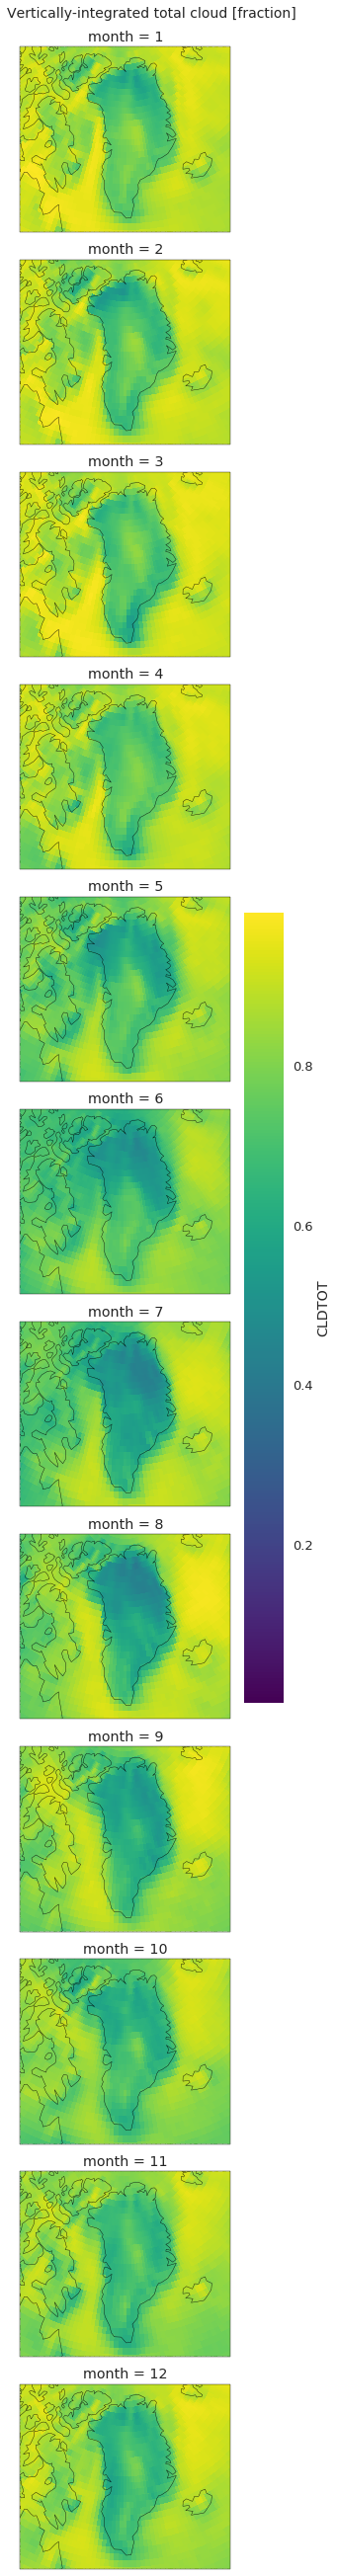

In [7]:
meanmonth_plots('CLDTOT')

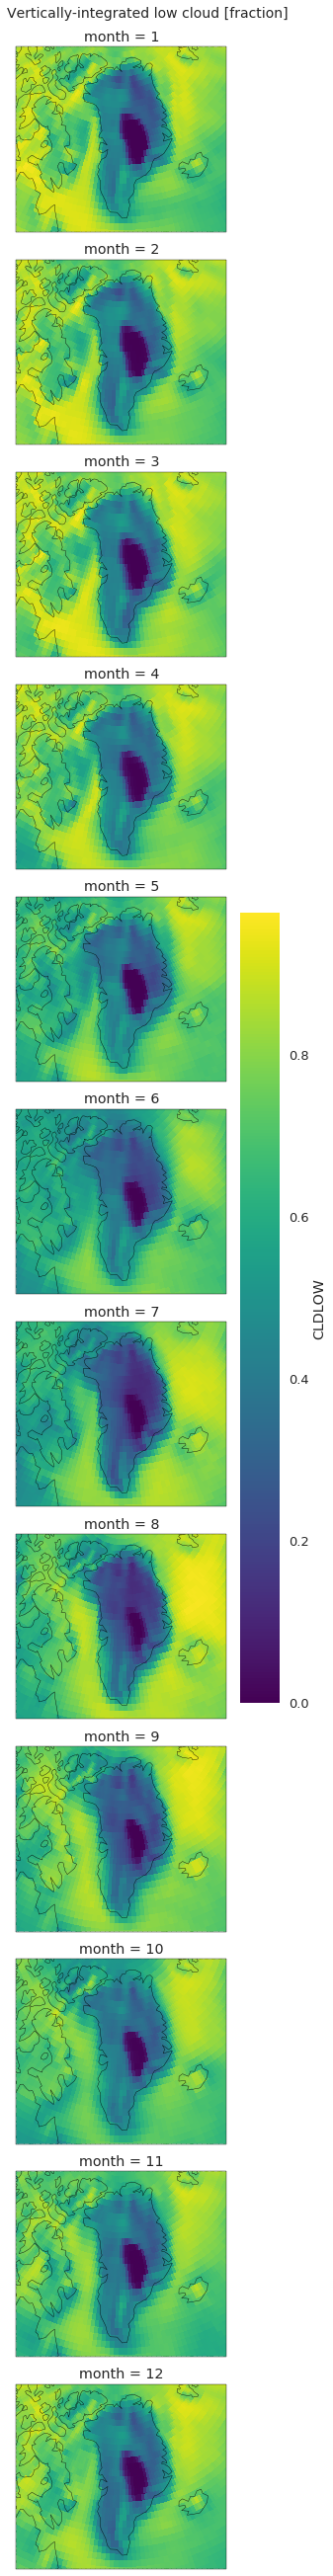

In [8]:
meanmonth_plots('CLDLOW')

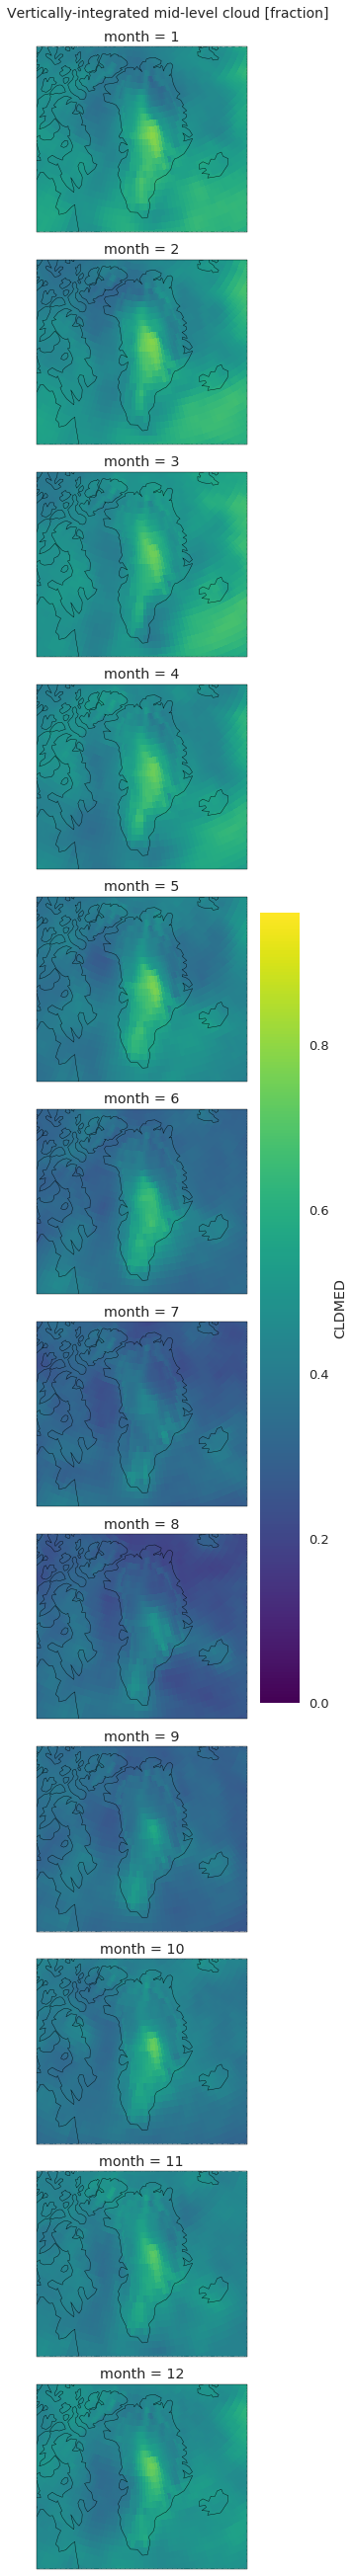

In [9]:
meanmonth_plots('CLDMED')

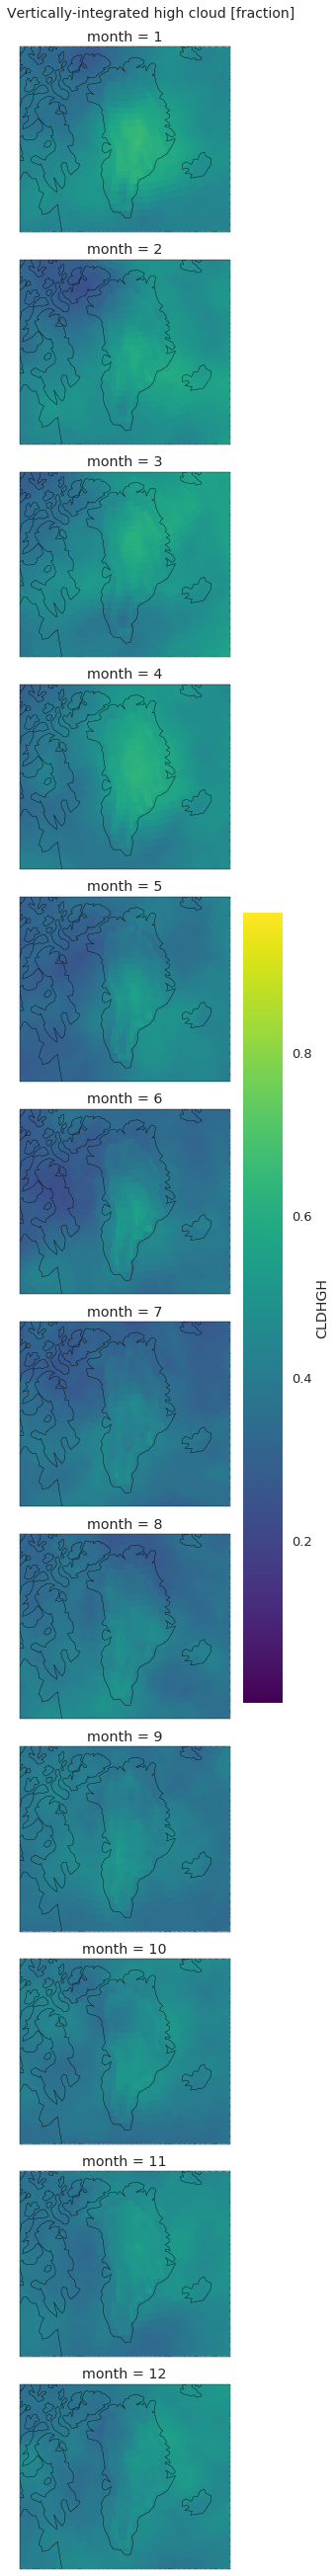

In [10]:
meanmonth_plots('CLDHGH')

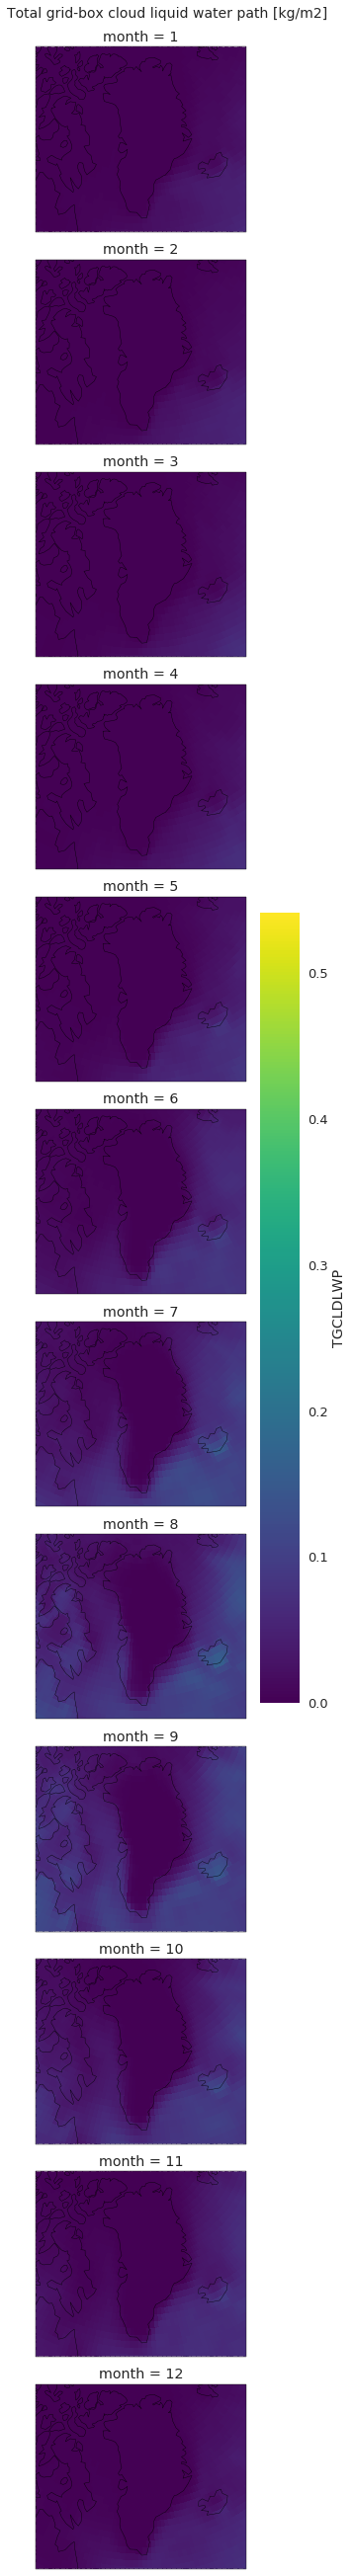

In [11]:
meanmonth_plots('TGCLDLWP')

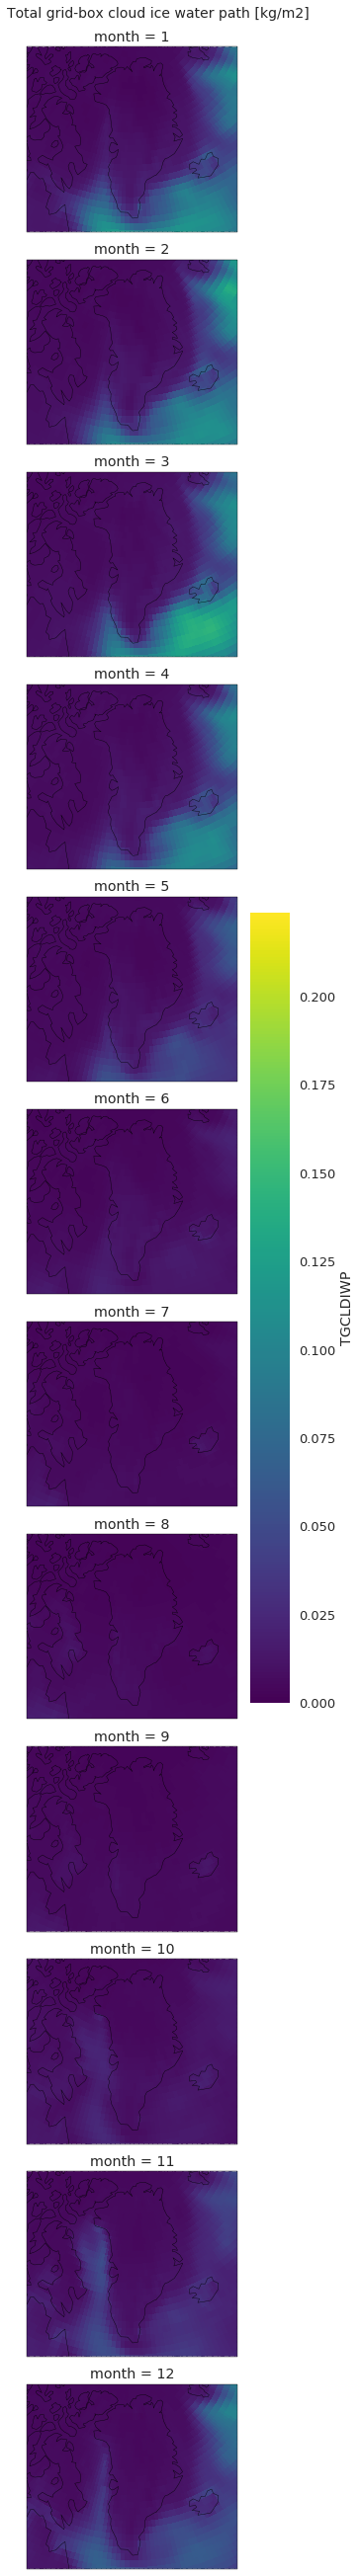

In [12]:
meanmonth_plots('TGCLDIWP')